# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generate Data

First, let's generate some unlabelled data:


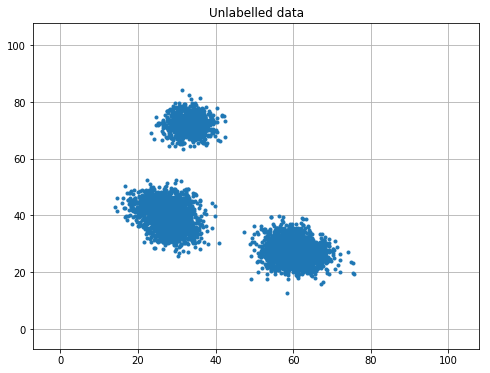

In [2]:
dimensions = 2
nclusters = 5
covariance = 10
npoints = 1000
minRange = 10
maxRange = 100

dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                      labelled=False, random_flip=True, nonlinearities=False)

if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,6)
    plot_data(dataset, "Unlabelled data", ax, labels=False)
    plt.savefig("../Figures/unlabelled-data.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

#### Create single Density Tree

In [3]:
import warnings
warnings.filterwarnings("ignore")
root = create_density_tree(dataset, dimensions=dimensions, clusters=nclusters, verbose=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating node (4 remaining)
Creating node (3 remaining)


  0%|          | 0/2 [00:00<?, ?it/s]

Creating node (2 remaining)
Creating node (1 remaining)


100%|██████████| 2/2 [00:00<00:00, 19.53it/s]


In [4]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals).astype(float)
cut_dims = np.asarray(cut_dims).astype(int)

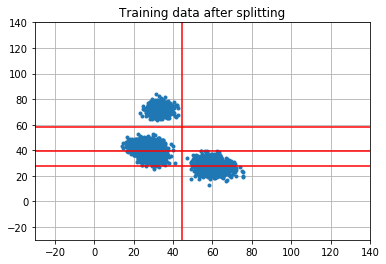

In [5]:
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split,
              minrange=minRange, maxrange=maxRange, covariance=covariance)

    %clear
    plt.show()

In [6]:
print(cut_dims, cut_vals)

[0 1 1 1] [44.54385057 58.21239562 39.27493942 27.386621  ]


# Printing the Tree

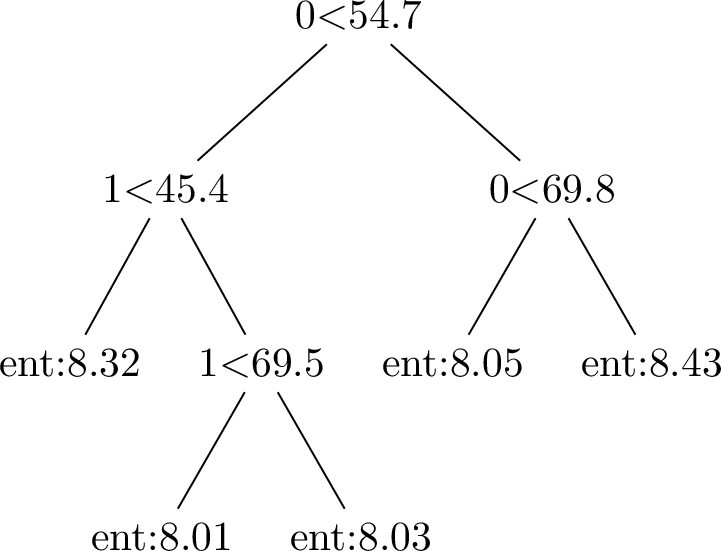

In [7]:
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    
    os.system("cd ../Figures; rm main.tex; more main_pt1.tex >> density-tree.tex; echo '' >> density-tree.tex;")
    os.system("cd ../Figures; echo '" + tree_string + "' >> density-tree.tex;  more main_pt2.tex >> density-tree.tex;")
    os.system("cd ../Figures; /Library/TeX/texbin/pdflatex density-tree.tex; convert -density 300 -trim density-tree.pdf -quality 100 density-tree.png")
    os.system("cd ../Figures; rm *.aux *.log")
    display(Image('../Figures/density-tree.png', retina=True))
    
tree_visualize(root)

#### Showing all Clusters Covariances

In [8]:
covs, means = get_clusters(root, [], [])

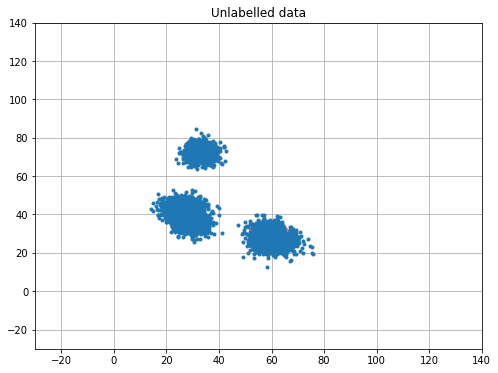

[0 1 1 1] [44.54385057 58.21239562 39.27493942 27.386621  ]


In [9]:
if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,6)
    plot_data(dataset, "Unlabelled data", ax, labels=False, covs=covs, means=means,
              minrange = minRange, maxrange = maxRange, covariance=covariance)
    plt.savefig("../Figures/unlabelled-data-cov.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    print(cut_dims, cut_vals)

#### Descend tree (predict "label")

In [10]:
# for all points 
probas = []
probas_other = []
for d in dataset:
    # descend tree
    d_mean, d_cov, d_pct = descend_density_tree(d,root)

    # probability for this point to be from this distribution
    probas.append(multivariate_normal.pdf(d, d_mean, d_cov)*d_pct)
    for i in range(5):
        probas_other.append(multivariate_normal.pdf(d, means[i], covs[i])*d_pct)
    
print("Probability to come from the leaf node cluster: %.5f%%" % np.mean(probas))
print("Probability to come from an arbitrary cluster: %.5f%%" % np.mean(probas_other))

Probability to come from the leaf node cluster: 0.00172%
Probability to come from an arbitrary cluster: 0.00037%


#### Density Forest

In [11]:
root_nodes = density_forest_create(dataset, dimensions, nclusters, 10, .3, -1)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.7s finished


In [12]:
def density_forest_traversex(dataset, root_nodes, thresh=.1):
    """
    traverse random forest and get labels
    TO DO don't traverse all points individually!
    1. Get all clusters (cov + mean) for all points
    2. For every cluster, get all probabilities from all point - cluster combinations
    """

    # get probability
    pairs_points = []
    pairs_mean = []
    pairs_cov = []
    pairs_pct = []
    
    # first, get all clusters for all points in all trees
    for d in dataset: 
        # traverse all trees
        d_probas = []
        for tree in root_nodes:
            d_mean, d_cov, d_pct = descend_density_tree(d, tree) #  TODO consider using only majority cluster?
            pairs_points.append(d)
            pairs_mean.append(d_mean)
            pairs_cov.append(d_cov)
            pairs_pct.append(d_pct)
     
    pairs_proba = np.zeros(len(pairs_points)) # for every point + tree there will be one probability
    pairs_points = np.asarray(pairs_points)
    
    # loop over every tree + cluster
    for t in tqdm(root_nodes):
        covs, means = get_clusters(t,[],[])
        # loop over clusters
        for c, m in zip(covs, means):
            indexes = (np.equal(np.mean(pairs_mean,-1),np.mean(m,-1)))&(np.greater(pairs_pct,.3))[0]
            if sum(indexes*1):
                sub_pairs_points = pairs_points[indexes]
                pairs_probas = multivariate_normal.pdf(sub_pairs_points, m, c)
                pairs_proba[indexes] = pairs_probas
            
            
    d_proba_mean = []
    # loop over every point
    for d in dataset:
        d_mean_proba = np.mean(pairs_proba[np.all(np.equal(pairs_points,d))])
        d_proba_mean.append(d_mean_proba)
   
    d_proba_mean = np.asarray(d_proba_mean)
    return d_proba_mean


In [13]:
#pairs_points, pairs_mean, m = density_forest_traversex(dataset, root_nodes, thresh = .2)
d_proba_mean = density_forest_traversex(dataset, root_nodes, thresh = .2)

100%|██████████| 10/10 [00:01<00:00,  9.32it/s]


In [15]:
x = dataset[1]
x_several = dataset[:100]
cov = covs[0]
mu = means[3]
def my_multivariate_normal_pdf(x,mu,cov):
    """custom function"""
    return 1/np.sqrt(np.linalg.det(2*np.pi*cov))*np.exp(-1/2*np.dot(np.dot(np.transpose(x-mu),np.linalg.inv(cov)),(x-mu)))

def scipy_multivariate_normal_pdf(x,mu,cov):    
    return multivariate_normal.pdf(x,mu,cov)